In [1]:
import rich
from rich import print
import wandb
import fastai
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback

set_seed(2022)

# CamVid

In [2]:
path = untar_data(URLs.CAMVID)

codes = np.loadtxt(path/'codes.txt', dtype=str)
fnames = get_image_files(path/"images")

In [4]:
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [5]:
# set_seed(2022)
# random.sample(fnames, k=int(0.2*len(fnames)), )

In [6]:
fnames[0], label_func(fnames[0])

(Path('/home/paperspace/.fastai/data/camvid/images/Seq05VD_f04290.png'),
 Path('/home/paperspace/.fastai/data/camvid/labels/Seq05VD_f04290_P.png'))

we can actually fix the split:

In [10]:
random.seed(2022)
val_idxs = random.sample(range_of(len(fnames)), k=int(0.2*len(fnames)))

In [11]:
block = DataBlock(blocks =(ImageBlock, MaskBlock(codes=codes)),
                  get_y  = label_func,
                  item_tfms = Resize((720//4, 960//4)),
                  splitter = IndexSplitter(val_idxs))

In [357]:
# set_seed(2022)

dls = SegmentationDataLoaders.from_label_func(
    path, 
    bs=8, 
    fnames = fnames, 
    label_func = label_func, 
    codes = codes, 
    item_tfms = Resize((720//4, 
                        960//4)),
    # batch_tfms = tfms,
)

set(dls.valid.dataset.items)

{Path('/home/paperspace/.fastai/data/camvid/images/0001TP_007080.png'),
 Path('/home/paperspace/.fastai/data/camvid/images/0001TP_007140.png'),
 Path('/home/paperspace/.fastai/data/camvid/images/0001TP_007230.png'),
 Path('/home/paperspace/.fastai/data/camvid/images/0001TP_007830.png'),
 Path('/home/paperspace/.fastai/data/camvid/images/0001TP_007920.png'),
 Path('/home/paperspace/.fastai/data/camvid/images/0001TP_008010.png'),
 Path('/home/paperspace/.fastai/data/camvid/images/0001TP_008340.png'),
 Path('/home/paperspace/.fastai/data/camvid/images/0001TP_008370.png'),
 Path('/home/paperspace/.fastai/data/camvid/images/0001TP_008400.png'),
 Path('/home/paperspace/.fastai/data/camvid/images/0001TP_008460.png'),
 Path('/home/paperspace/.fastai/data/camvid/images/0001TP_008520.png'),
 Path('/home/paperspace/.fastai/data/camvid/images/0001TP_008640.png'),
 Path('/home/paperspace/.fastai/data/camvid/images/0001TP_008670.png'),
 Path('/home/paperspace/.fastai/data/camvid/images/0001TP_008700

## Table

In [25]:
class_labels = {i:c for i,c in enumerate(codes)}

In [27]:
class_labels

{0: 'Animal',
 1: 'Archway',
 2: 'Bicyclist',
 3: 'Bridge',
 4: 'Building',
 5: 'Car',
 6: 'CartLuggagePram',
 7: 'Child',
 8: 'Column_Pole',
 9: 'Fence',
 10: 'LaneMkgsDriv',
 11: 'LaneMkgsNonDriv',
 12: 'Misc_Text',
 13: 'MotorcycleScooter',
 14: 'OtherMoving',
 15: 'ParkingBlock',
 16: 'Pedestrian',
 17: 'Road',
 18: 'RoadShoulder',
 19: 'Sidewalk',
 20: 'SignSymbol',
 21: 'Sky',
 22: 'SUVPickupTruck',
 23: 'TrafficCone',
 24: 'TrafficLight',
 25: 'Train',
 26: 'Tree',
 27: 'Truck_Bus',
 28: 'Tunnel',
 29: 'VegetationMisc',
 30: 'Void',
 31: 'Wall'}

In [6]:
def get_preds(learn):
    inp,preds,targs,out = learn.get_preds(with_input=True, with_decoded=True)
    b = tuplify(inp) + tuplify(targs)
    x, y, samples,outs = learn.dls.valid.show_results(b, out, show=False, max_n=36)
    return samples, outs, preds

In [7]:
def create_table(samples, outs, preds):
    "Creates a wandb table with preds and targets side by side"
    res = []
    table = wandb.Table(columns=["image", "preds", "targets"])
    for (image, label), pred_label in zip(samples, outs):
        img = image.permute(1,2,0)
        table.add_data(wandb.Image(img),
                       wandb.Image(img, masks={"pred":  {'mask_data':  pred_label[0].numpy(), 'class_labels':class_labels}}),
                       wandb.Image(img, masks={"target": {'mask_data': label.numpy(), 'class_labels':class_labels}}))
    return table

## Prepare for sweep

In [12]:
#ready for sweeps
config = {"arch": "resnet34",
          "batch_size": 16,
          "loss_func": "FocalLossFlat",
          "lr": 0.002,
          "resize_factor":4}

def run_train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        logger = WandbCallback(log_preds=False)
        
        # dataloaders
        # tfms = aug_transforms()
        dls = SegmentationDataLoaders.from_label_func(
            path, 
            bs=config.batch_size, 
            fnames = fnames, 
            label_func = label_func, 
            codes = codes, 
            item_tfms = Resize((720//config.resize_factor, 
                                960//config.resize_factor)),
            # batch_tfms = tfms,
        )

        # model
        cbs = [SaveModelCallback(fname=f"unet_{config.arch}"), logger, MixedPrecision()]
        
        loss_func = getattr(fastai.losses, config.loss_func)(axis=1)
        model = {"resnet34":resnet34, "xresnet34":xresnet34, "xresnext34":xresnext34}
        learn = unet_learner(dls, 
                             model[config.arch],
                             metrics = [DiceMulti(), foreground_acc],
                             loss_func = loss_func,
                             cbs = cbs)
        learn.fine_tune(10, base_lr=config.lr)

In [14]:
def get_data(batch_size, resize_factor=4, augment=True, seed=2022):
    "Get dataloader"
    # get dataset
    path = untar_data(URLs.CAMVID)
    codes = np.loadtxt(path/'codes.txt', dtype=str)
    fnames = get_image_files(path/"images")
    
    # datalaoders
    tfms = aug_transforms() if augment else None
    dls = SegmentationDataLoaders.from_label_func(
        path, 
        bs=batch_size, 
        fnames = fnames, 
        label_func = label_func, 
        codes = codes, 
        seed = seed,
        item_tfms = Resize((720//resize_factor, 
                            960//resize_factor)),
        batch_tfms = tfms,
    )
    return dls

In [15]:
dls = get_data(batch_size=8)

In [23]:
def get_learner(dls, arch, loss_func):
    cbs = [SaveModelCallback(fname=f"unet_{arch}"), 
           WandbCallback(log_preds=False), 
           MixedPrecision()]

    learn = unet_learner(dls, 
                         arch,
                         metrics = [DiceMulti(), foreground_acc],
                         loss_func = loss_func(axis=1),
                         cbs = cbs)
    return learn

In [24]:
config = {"arch": "resnet34",
          "batch_size": 16,
          "loss_func": "FocalLossFlat",
          "lr": 0.002,
          "resize_factor":4,
          "augment":True}

with wandb.init(project="CamVid", entity="hydranet", name="baseline", config=config):
    config = wandb.config
    dls = get_data(config.batch_size, config.resize_factor, config.augment)
    
    archs = {"resnet34":resnet34, "xresnet34":xresnet34, "xresnext34":xresnext34}
    learn = get_learner(dls, archs[config.arch], getattr(fastai.losses, config.loss_func))
    learn.fine_tune(10, base_lr=config.lr)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tcapelle (use `wandb login --relogin` to force relogin)


epoch,train_loss,valid_loss,dice_multi,foreground_acc,time
0,1.646285,0.870226,0.078594,0.629438,00:16


Better model found at epoch 0 with valid_loss value: 0.8702263832092285.


epoch,train_loss,valid_loss,dice_multi,foreground_acc,time
0,0.735549,0.600424,0.147459,0.738320,00:08
1,0.618079,0.474655,0.211528,0.806193,00:08
2,0.525309,0.402983,0.252186,0.812491,00:08
3,0.457929,0.362936,0.306893,0.825831,00:08
4,0.397234,0.307702,0.331151,0.847895,00:08
5,0.346901,0.278763,0.363740,0.859010,00:07
6,0.307311,0.259840,0.379878,0.869012,00:08
7,0.276900,0.250251,0.407051,0.870738,00:08
8,0.254385,0.238473,0.430604,0.876575,00:08
9,0.239340,0.237122,0.432295,0.876373,00:08


Better model found at epoch 0 with valid_loss value: 0.60042405128479.
Better model found at epoch 1 with valid_loss value: 0.4746551513671875.
Better model found at epoch 2 with valid_loss value: 0.40298303961753845.
Better model found at epoch 3 with valid_loss value: 0.36293649673461914.
Better model found at epoch 4 with valid_loss value: 0.3077024519443512.
Better model found at epoch 5 with valid_loss value: 0.2787632942199707.
Better model found at epoch 6 with valid_loss value: 0.25984030961990356.
Better model found at epoch 7 with valid_loss value: 0.25025123357772827.
Better model found at epoch 8 with valid_loss value: 0.2384731024503708.
Better model found at epoch 9 with valid_loss value: 0.23712177574634552.


dice_multi,▁▂▄▄▆▆▇▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
foreground_acc,▁▄▆▆▇▇█████
lr_0,▁▃▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▃▅█▂▂▂▂▃▃▄▄▄▄▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
lr_2,▁▃▅█▂▂▂▂▃▃▄▄▄▄▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▆▄▁██▇▆▅▅▃▃▂▁▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▅▆▆▇▇▇█████
mom_1,█▆▄▁██▇▆▅▅▃▃▂▁▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▅▆▆▇▇▇█████


In [12]:
run_train(config)

In [ ]:
def log_table(learn):
    table = create_table(*get_preds(learn))
    wandb.log({"Predictions":table})

In [8]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1, alpha=1):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

## MLP

In [106]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    return nn.Sequential(
        dense(dim, dim * expansion_factor),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(dim * expansion_factor, dim),
        nn.Dropout(dropout)
    )

def MLPSegmentationMixer(image_size, channels, patch_size, dim, depth, out_channels=3, expansion_factor = 4, dropout = 0.):
    assert (image_size[0] % patch_size) == 0, 'image must be divisible by patch size'
    h, w = (image_size[0] // patch_size) , (image_size[1] // patch_size) 
    num_patches = h*w
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        nn.Linear(dim, (patch_size ** 2) * out_channels),
        Rearrange('b (h w) (p1 p2 c) -> b c (h p1) (w p2)', c=out_channels, h=h, p1 = patch_size, p2 = patch_size),
    )

In [134]:
mlp_mixer = MLPSegmentationMixer((180, 240), 3, 20, 1024, 6, len(codes))

In [135]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=64, fnames = fnames, label_func = label_func, codes = codes, item_tfms=Resize((360//2,480//2))
)

In [136]:
learn2 = Learner(dls, mlp_mixer, loss_func=CrossEntropyLossFlat(axis=1), metrics=[DiceMulti(), foreground_acc])

SuggestedLRs(valley=0.00013182566908653826)

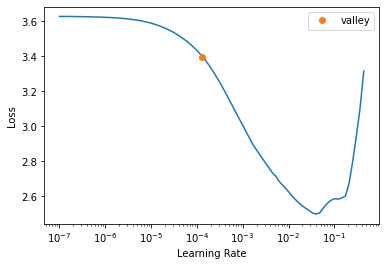

In [137]:
learn2.lr_find()

In [133]:
learn2.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,dice_multi,foreground_acc,time
0,2.150888,1.486428,0.072149,0.571200,00:05
1,1.547103,1.171696,0.107280,0.602114,00:05
2,1.290867,1.061671,0.134800,0.676842,00:06
3,1.119405,0.917001,0.165706,0.728370,00:05
4,0.979992,0.850557,0.220480,0.744956,00:05
5,0.873434,0.780932,0.238645,0.766857,00:06
6,0.784772,0.737917,0.257262,0.783211,00:05
7,0.719835,0.716319,0.281181,0.786466,00:05


Exception ignored in: <function _releaseLock at 0x7f85733f23a0>
Traceback (most recent call last):
  File "/home/paperspace/mambaforge/envs/fastai/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 20016) exited unexpectedly